# Frequency Domain Filtering

Normally, we think of an image as a rectangular array of pixels, each pixel representing an intensity at a position in the spatial domain. However, some operations are complicated, or impossible to perform in the spatial domain, and; therefore, a different representation is required.

Representing an image as the sum of sinusoidal waves places it in the frequency domain in which certain denoising and smoothing operations on the periodic structure are possible.
We convert an image to a spectrum in the frequency domain via the Discrete Fourier transformation (DFT) {cite}`fourierAnalyticalTheoryHeat2007`. It has two components: **magnitude** and **phase**. The magnitude tells us *how much* a certain frequency component is present, and the phase tells us *where* the frequency component is in the image.

To get some intuition into the frequency domain representation, we plot the DFTs of a few simple images. In general, we plot the *magnitude* images and **not** the *phase* images [^phase].

[^phase]: The case reports of people who have studied phase images shortly thereafter succumbing to hallucinogenics or ending up in a Tibetan monastery {cite}`IntroductionFourierTransform`  have not been corroborated. Nonetheless, the study of phase images in the frequency domain is best avoided.

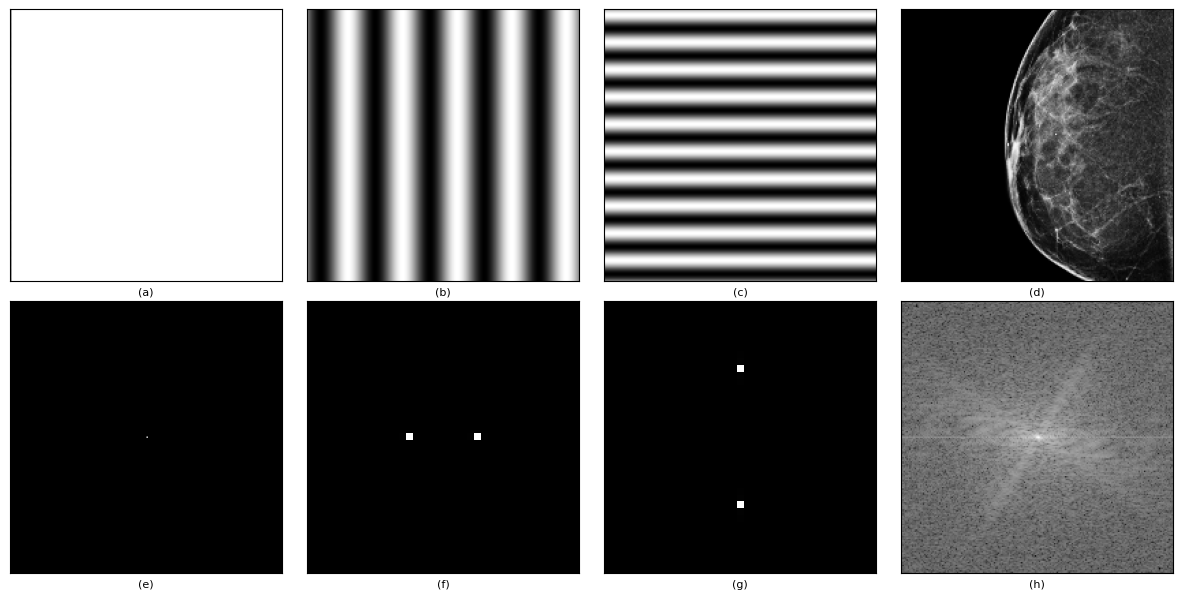

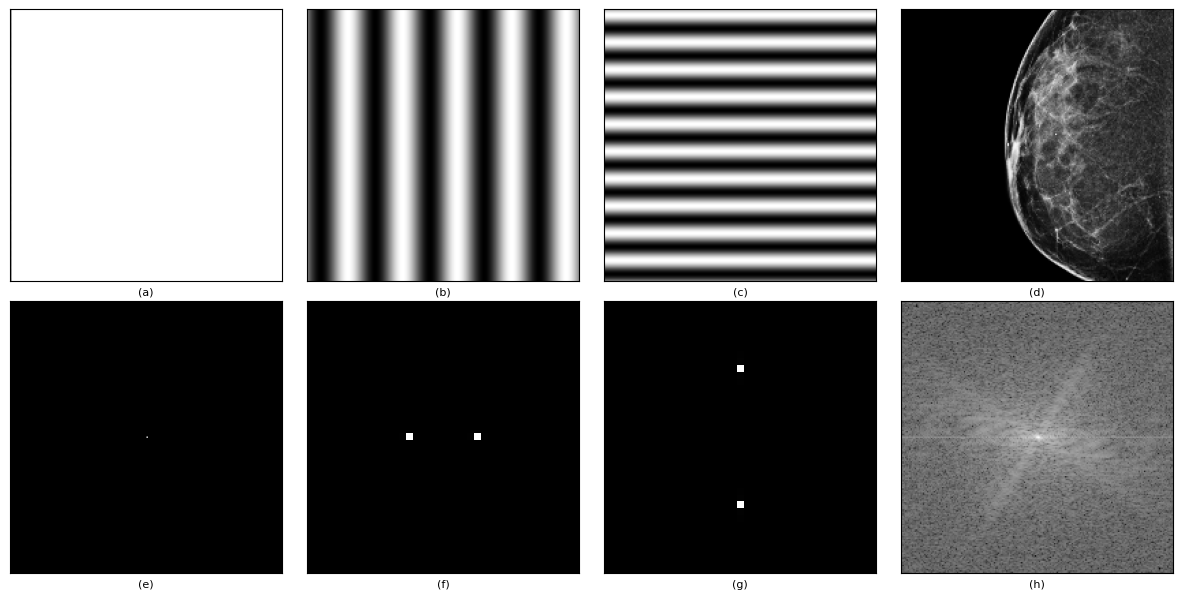

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))
import cv2
import matplotlib.pyplot as plt
import numpy as np
from bcd.utils.image import convert_uint8
from myst_nb import glue

FP_WHITE = "jbook/figures/frequency_white.jpg"
FP_MMG = "jbook/figures/mammogram.png"

def create_image(wavelength = 200, angle = 0):
    x = np.arange(-500,501,1)
    X,Y = np.meshgrid(x,x)
    return np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)

def get_image(fp: str, size: int = 200):
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (size,size))

def transform_image(img):
    # Shift the input
    img = np.fft.ifftshift(img)
    # Compute fourier transformation
    img = np.fft.fft2(img)
    # Shift the zero-frequency to the center
    img = np.fft.fftshift(img)
    # Compute amplitude
    img = np.abs(img)
    return img


img_white = get_image(fp=FP_WHITE)
img_hline = create_image()
img_vline = create_image(angle=2 * np.pi / 4, wavelength=100)
img_mmg = get_image(fp=FP_MMG)

img_white_fft = transform_image(img_white)
img_hline_fft = transform_image(img_hline)
img_vline_fft = transform_image(img_vline)
img_mmg_fft = transform_image(img_mmg)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
_ = axes[0,0].imshow(img_white, cmap='gray')
_ = axes[0,1].imshow(img_hline, cmap='gray')
_ = axes[0,2].imshow(img_vline, cmap='gray')
_ = axes[0,3].imshow(img_mmg, cmap='gray')

_ = axes[1,0].imshow(img_white_fft, cmap='gray')
_ = axes[1,1].imshow(img_hline_fft, cmap='gray')
_ = axes[1,1].set_xlim([480,520])
_ = axes[1,1].set_ylim([520,480])
_ = axes[1,2].imshow(img_vline_fft, cmap='gray')
_ = axes[1,2].set_xlim([520,480])
_ = axes[1,2].set_ylim([480,520])
_ = axes[1,3].imshow(np.log(img_mmg_fft), cmap='gray')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("fft", fig)

```{glue:figure} fft
---
align: center
name: fft_fig
---
Discrete Fourier Transformation
```